In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
from habitat.utils.visualizations import maps
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import cv2
import ast

In [2]:
def plot_colortable(colors, title, sort_colors=False, emptycols=0):
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left")

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)
        
    plt.show()

In [3]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [4]:
def draw_top_down_map(mapp,fogg,cordd, heading, output_size):
    top_down_map = maps.colorize_topdown_map(
        mapp, fogg
    )
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = cordd
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

# Load HDF5 File

In [5]:
file = h5py.File('data1.hdf5', 'r')

In [6]:
rgb = file['rgb']
depth = file['depth']
semantic = file['semantic']
objectgoal = file['objectgoal']
compass = file['compass']
gps = file['gps']
heading = file['heading']
top_down_map = file['top_down_map']
fog_of_war_mask = file['fog_of_war_mask']
agent_map_coord = file['agent_map_coord']
agent_angle = file['agent_angle']
mapping = np.array(file['mapping'])
index_to_title_map = ast.literal_eval(str(np.array(file['index_to_title_map']))[2:-1])

# Examples of what inside

In [7]:
print('Full trajectory has {} steps'.format(len(rgb)))

Full trajectory has 134 steps


In [8]:
# Pick frame number 133 to all further examples
index = 133

In [25]:
print('Goal object is {} - {}'.format(objectgoal[index],index_to_title_map[objectgoal[index][0]]))
print('GPS position {}'.format(gps[index]))
print('Compas position {}'.format(compass[index]))

Goal object is [12] - curtain
GPS position [-5.1342635  6.023223 ]
Compas position [2.6179938]


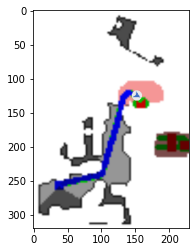

In [18]:
mapp = draw_top_down_map(top_down_map[index],fog_of_war_mask[index],agent_map_coord[index],heading[index][0],rgb[index].shape[0])
plt.imshow(mapp)

In [19]:
# Dictionary of what indices corresponds to objects
index_to_title_map

{1: 'wall',
 40: 'misc',
 16: 'stairs',
 4: 'door',
 2: 'floor',
 39: 'objects',
 17: 'ceiling',
 0: 'void',
 14: 'plant',
 24: 'column',
 -1: '',
 5: 'table',
 21: 'mirror',
 15: 'sink',
 7: 'cabinet',
 28: 'lighting',
 34: 'seating',
 20: 'towel',
 12: 'curtain',
 9: 'window',
 23: 'shower',
 38: 'clothes',
 11: 'bed',
 35: 'board_panel',
 37: 'appliances',
 31: 'shelving',
 26: 'counter',
 22: 'tv_monitor',
 3: 'chair'}

In [27]:
len(index_to_title_map.keys())

29

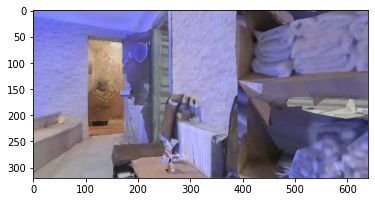

In [20]:
plt.imshow(rgb[index])

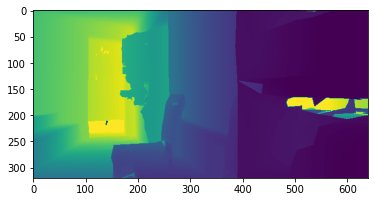

In [21]:
plt.imshow(depth[index][:,:,0])

Number of labels: 277


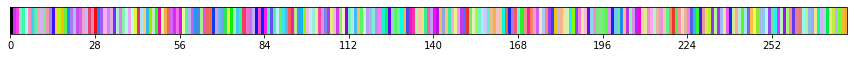

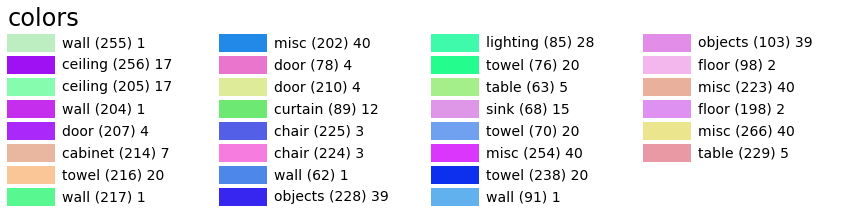

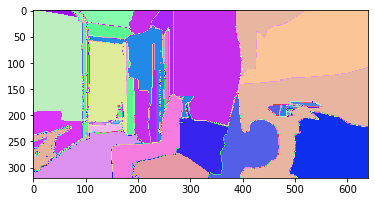

In [22]:
# Semantic sensor output with annotation, number in brackets is item number
# number after brackets is number that corresponds to each object 
# (different chairs has different number in brackets but same number after brackets)
semantic_image = semantic[index]

elements_in_image = []
    
for string in semantic_image:
    for el in string:
        if not(el in elements_in_image):
            elements_in_image.append(el)
            
colors = list(mcolors.CSS4_COLORS.values())
new_colors = colors
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))            
ccmap = matplotlib.cm.get_cmap('jet')   
new_cmap = rand_cmap(len(mapping), type='bright', first_color_black=True, last_color_black=False, verbose=True)
colorss = {}

for i,entry in enumerate(elements_in_image):
    label = index_to_title_map[mapping[entry]] + ' (' + str(entry)+ ') ' + str(mapping[entry])
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=len(mapping))
    
    colorss[label] = new_cmap(norm(entry))
        
plot_colortable(colorss, 'colors')
    
plt.imshow(semantic_image, cmap=new_cmap, vmin=-1, vmax=len(mapping))
plt.show()    